# Machine Predictive Maintenance

## Business Case

A manufacturer in custom metal products (Northrup Grumman) has approached our company looking to reduce the amount of downtime on their machines in their facility. In order to do so, they intend to focus on preventative maintenance procedures to avoid machine failures. A machine failure can occur for a variety of reasons which leads to a stop in the manufacturing process, and is creating a bottleneck in production at times when their machines are most needed. In addition, some failures result in damage to the machine, which can incur additional maintenance over time. 

They would like a product that (based on the data provided) can predict what type of failure would occur when the machine does fail. The manufacturing company has provided us with the two and a half months of data for one of their machines. If we should be successful in assisting their company, they would be willing to invest additional resources in expanding this project as well as gathering data for other machines in order to reduce downtime for them as well. 

## Disclaimer

The following project is a hypothetical scenario. Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

## Data Description


The dataset provided consists of 10 000 data points stored as rows with 9 different columns. These descriptions below are taken directly from the Kaggle site where the data was posted:

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

| Column Name  | Description  |
|---|---|
| UID  | unique identifier ranging from 1 to 10000  |
| productID  | consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number  |
| air temperature [K]  | generated using a random walk process later normalized to a standard deviation of 2 K around 300 K  |
| process temperature [K]  | generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K  |
| rotational speed [rpm]  | generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K  |
|  torque [Nm] |  torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values |
| tool wear [min]  |  The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process |
| Target  |  label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true |
| Failure Type  | Organized into 5 different types: No Failure, Heat Dissipation Failure, Power Failure, Tool Wear Failure, Random Failure  |

## Reading and Analyzing Data

We will start by importing the libraries required for the notebook and pulling in the data as well as ignoring warnings which were raised and addressed in completing the following notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, r2_score, mean_squared_error, classification_report
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier

from yellowbrick.classifier import ConfusionMatrix



import warnings
warnings.filterwarnings("ignore", message='From version 0.24, get_params will raise an ')
warnings.filterwarnings("ignore", message='Pass the following variable as a keyword arg: x. From version 0.12')
warnings.filterwarnings("ignore", message='The least populated class in y has only 4 members, which is less')
warnings.filterwarnings("ignore", message='SettingWithCopyWarning:')

In [2]:
# read csv
df = pd.read_csv("data/predictive_maintenance.csv")

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


We want to know what types of data we have. We will need to have all of the cloumns be a integer or float in order to use the dataframe in a model

In [3]:
# data types
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [4]:
# Number of failures and number of types of failure
print(df["Target"].value_counts())
print(df["Failure Type"].value_counts())
print(df["Failure Type"].value_counts(normalize=True)*100)

0    9661
1     339
Name: Target, dtype: int64
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: Failure Type, dtype: float64


It looks like the values for failure in the target column do not match the failure counts from the failure type columns. We will come back to this in preprocessing to eliminate these anomalies.

For now, we should determine the percentages of each failure (not including the no failure column) and take a look at these in a plot

In [5]:
# Calculate percentages for each failure
Fdf = df[df['Failure Type'] != 'No Failure']
Value_counts = Fdf["Failure Type"].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[32.18, 27.3, 22.41, 12.93, 5.17]

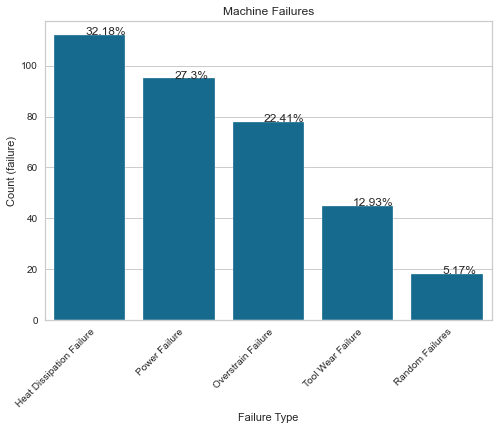

In [6]:
# Plot failure types and percentages in barplot

Failure_type = Fdf['Failure Type'].value_counts(sort=True)
Value_counts = Fdf["Failure Type"].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Failure_type.index, y=Failure_type.values, color='b')
ax.set(xlabel="Failure Type", ylabel="Count (failure)", title="Machine Failures")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)
        

plt.savefig('images/Machine-Failures.png', bbox_inches='tight')        
plt.show();




Heat dissipation, power, and overstrain seem to account for 80% of all of the failures we have. We will definitely have to be able to predict the first four categories of failures since most likely we will end up removing the random failures, as they seem to be anomalies.

In our business case, tool wear should be the lowest cost failure. Either the tool breaks, or the product comes out with a low quality finish. It would not cause the kind of damage and longer downtime in the machine that the other failures cause. So the tool wear failure is the least problematic to solve for out of all the failures. So we want to focus on solving for the other three primarily.

## Preprocessing Data

The first problem we have, right off the bat, is that the counts in the target column do not match the failure types indicated. So we have to (1) remove any row that indicates a 1 in the target column and no failure in the failure type column and (2) remove any row that indicates a 0 in the target column but indicates a failure type in the type column.

In [7]:
dfdrop1 = ((df['Target'] == 0) & (df["Failure Type"] != 'No Failure')) | ((df['Target'] == 1) & (df["Failure Type"] == 'No Failure'))
df1 = df[~dfdrop1]
df1

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


We also need to convert some of the data so that it is consistent in the dataset

In [8]:
df1 = df1.astype({"Rotational speed [rpm]":'float', "Tool wear [min]":'float', "Target":'float'}) 

And lets just double check for nulls in the dataset

In [9]:
df1.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Great none to be had. Lets convert the categorical columns to numeric for type and failure type.

In [10]:
from sklearn.preprocessing import LabelEncoder

df2 = df1.copy()

le = LabelEncoder()
le.fit(df2['Failure Type'].drop_duplicates()) 
df2['Failure Type'] = le.transform(df2['Failure Type'])
classes = list(le.classes_)
print(classes)

['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Tool Wear Failure']


In [11]:
# label encode type column
le.fit(df2['Type'].drop_duplicates()) 
df2['Type'] = le.transform(df2['Type'])

df3 = df2.copy()

df3.drop(['UDI', 'Product ID'], axis=1, inplace=True)
df3

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,298.1,308.6,1551.0,42.8,0.0,0.0,1
1,1,298.2,308.7,1408.0,46.3,3.0,0.0,1
2,1,298.1,308.5,1498.0,49.4,5.0,0.0,1
3,1,298.2,308.6,1433.0,39.5,7.0,0.0,1
4,1,298.2,308.7,1408.0,40.0,9.0,0.0,1
...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604.0,29.5,14.0,0.0,1
9996,0,298.9,308.4,1632.0,31.8,17.0,0.0,1
9997,2,299.0,308.6,1645.0,33.4,22.0,0.0,1
9998,0,299.0,308.7,1408.0,48.5,25.0,0.0,1


In [12]:
# show our new values for failure
df3['Target'].value_counts()

0.0    9643
1.0     330
Name: Target, dtype: int64

We would be interested to know how many times a failure happens in one day or one month. The tool wear column is being measured in minutes so we should be able to determine the interval between rows and use that to determine time on this.

In [13]:
# Make a copy of dataframe, take the difference of each row between rows, then make a new column with that difference measurement for each row
df4 = df3.copy()
df4['TWdiff'] =df3['Tool wear [min]'].diff()
# any values less than 0 will be equal to zero. these account for when the tool wear failure occurs and the tool wear counter goes back to zero in the dataset
df4.loc[df4['TWdiff'] < 0, 'TWdiff'] = 0
df4

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,TWdiff
0,2,298.1,308.6,1551.0,42.8,0.0,0.0,1,NaN
1,1,298.2,308.7,1408.0,46.3,3.0,0.0,1,3.0
2,1,298.1,308.5,1498.0,49.4,5.0,0.0,1,2.0
3,1,298.2,308.6,1433.0,39.5,7.0,0.0,1,2.0
4,1,298.2,308.7,1408.0,40.0,9.0,0.0,1,2.0
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604.0,29.5,14.0,0.0,1,2.0
9996,0,298.9,308.4,1632.0,31.8,17.0,0.0,1,3.0
9997,2,299.0,308.6,1645.0,33.4,22.0,0.0,1,5.0
9998,0,299.0,308.7,1408.0,48.5,25.0,0.0,1,3.0


In [14]:
# sum all values in difference row
df4['TWdiff'].sum(axis=0)

25691.0

25691 minutes of machine time data

So if we assumed the following:
- single shift for the company where the company works from 7am to 3:30pm
- the machine setup time accounts for 1 min for every 3 minutes on average the machine is run
- machines do not run for breaks, which account for one hour of the day

Then we would be left with 337.5 minutes per day that the machines run. So the overall time (calculated above) devided by 337.5 represents 76.1 working days on the machines. Considering the 330 failures we had, we would have 4.33 failures on average per day. We really want to get that down to less then one failure per day

## Visualizing the Data

Now that all of the columns are cleaned, we want to plot them and see how the data looks in comparison to the failures that have been happening. Hopefully we can identify which columns are the culprits in the failures.

In [15]:
#Create a color palette for each of the categories, to keep the colors consistent when No Failure is dropped from plots
palette = {'No Failure':"tab:blue", #blue blue
           'Power Failure':"#e17701", #pumpkin orange
           'Tool Wear Failure':"#89a203", #vomit green
           'Overstrain Failure':"#a00498", #barney
           'Heat Dissipation Failure':"#e50000"} #red

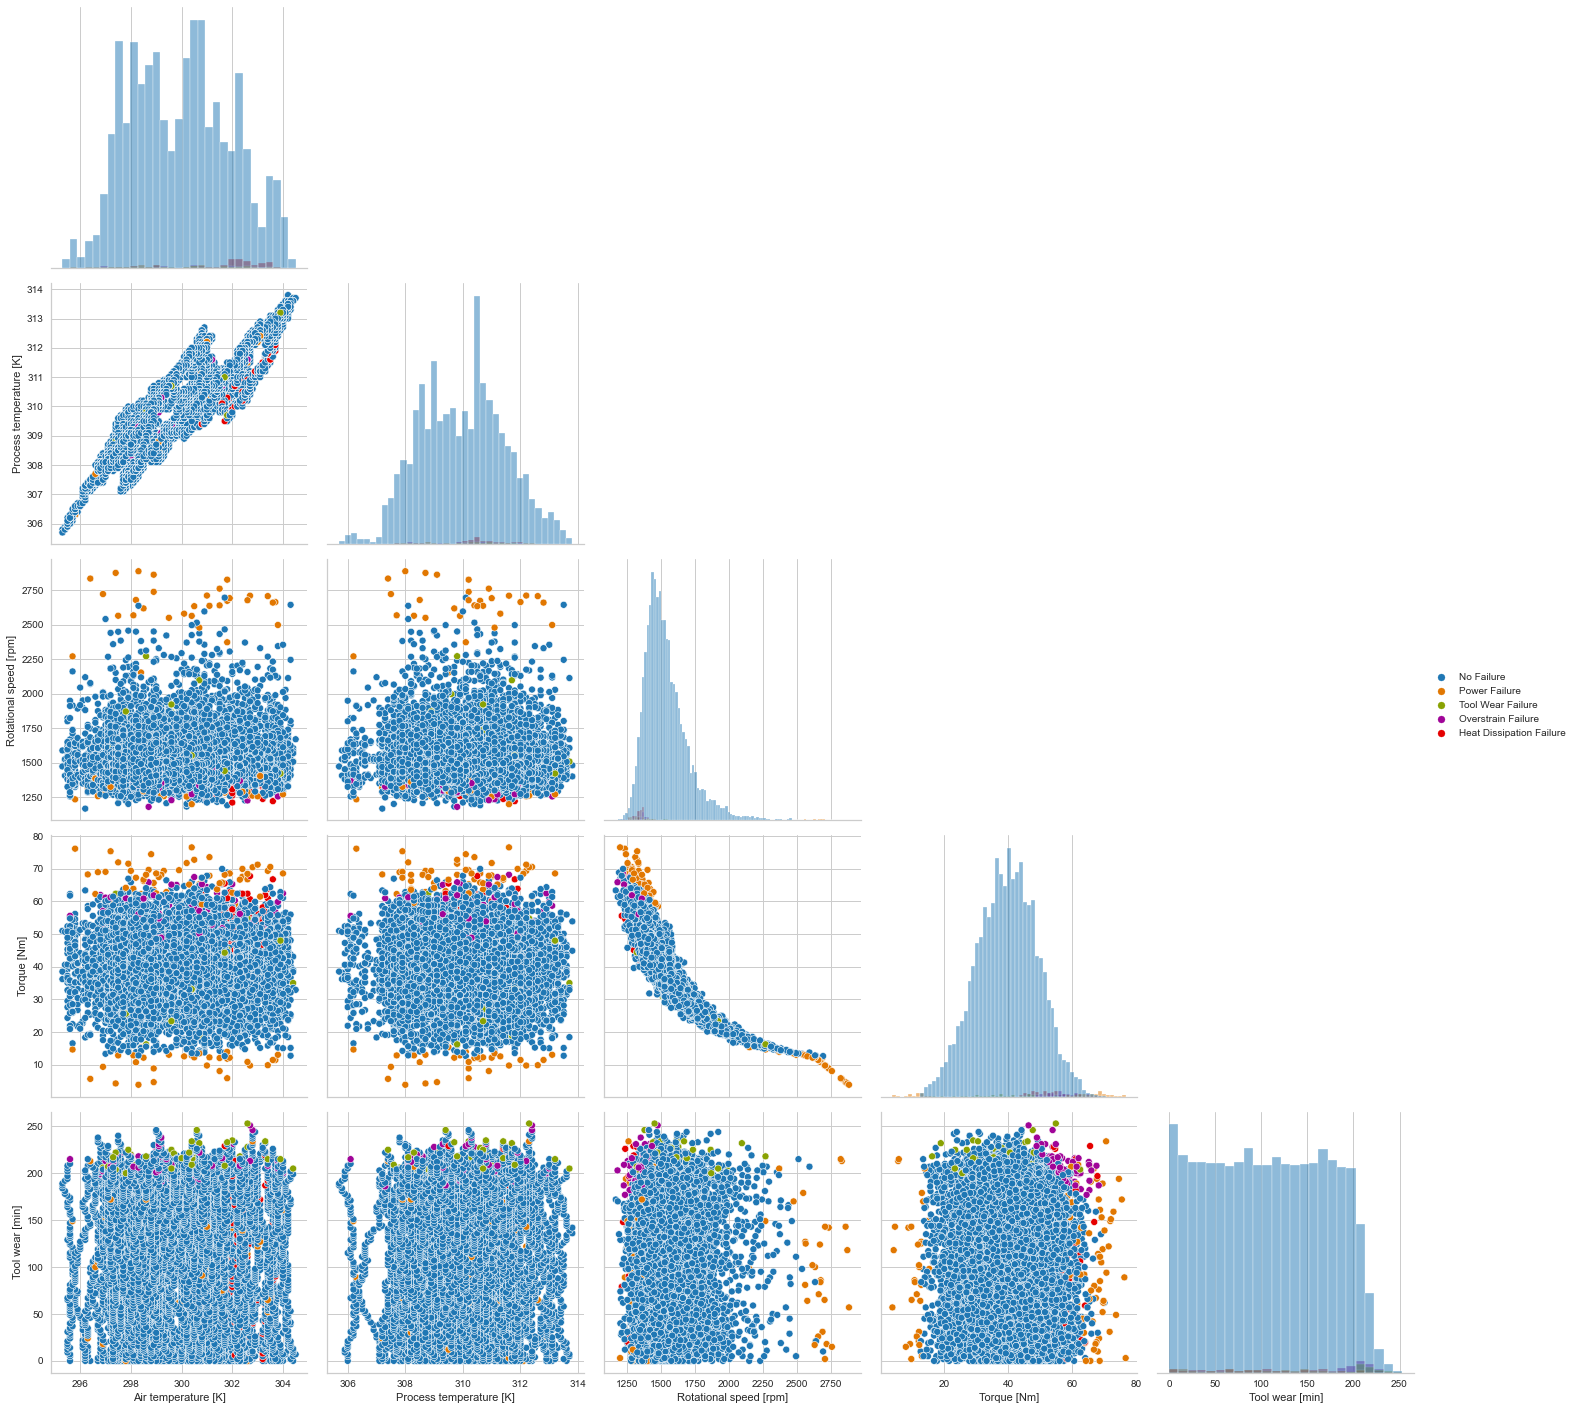

In [16]:
#plot all columns with each failure as a different color
df1plot1 = df1.drop(['UDI', 'Product ID', 'Target'], axis=1)

g = sns.PairGrid(df1plot1, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", );

It doesnt look like the process temperature and air temperature have much bearing on the failure of the machine. Also, the amount of no failures in the plot are too much to be able to see all of the other failures in the plots. Lets remove the data points that are not considered failures to get a better look.

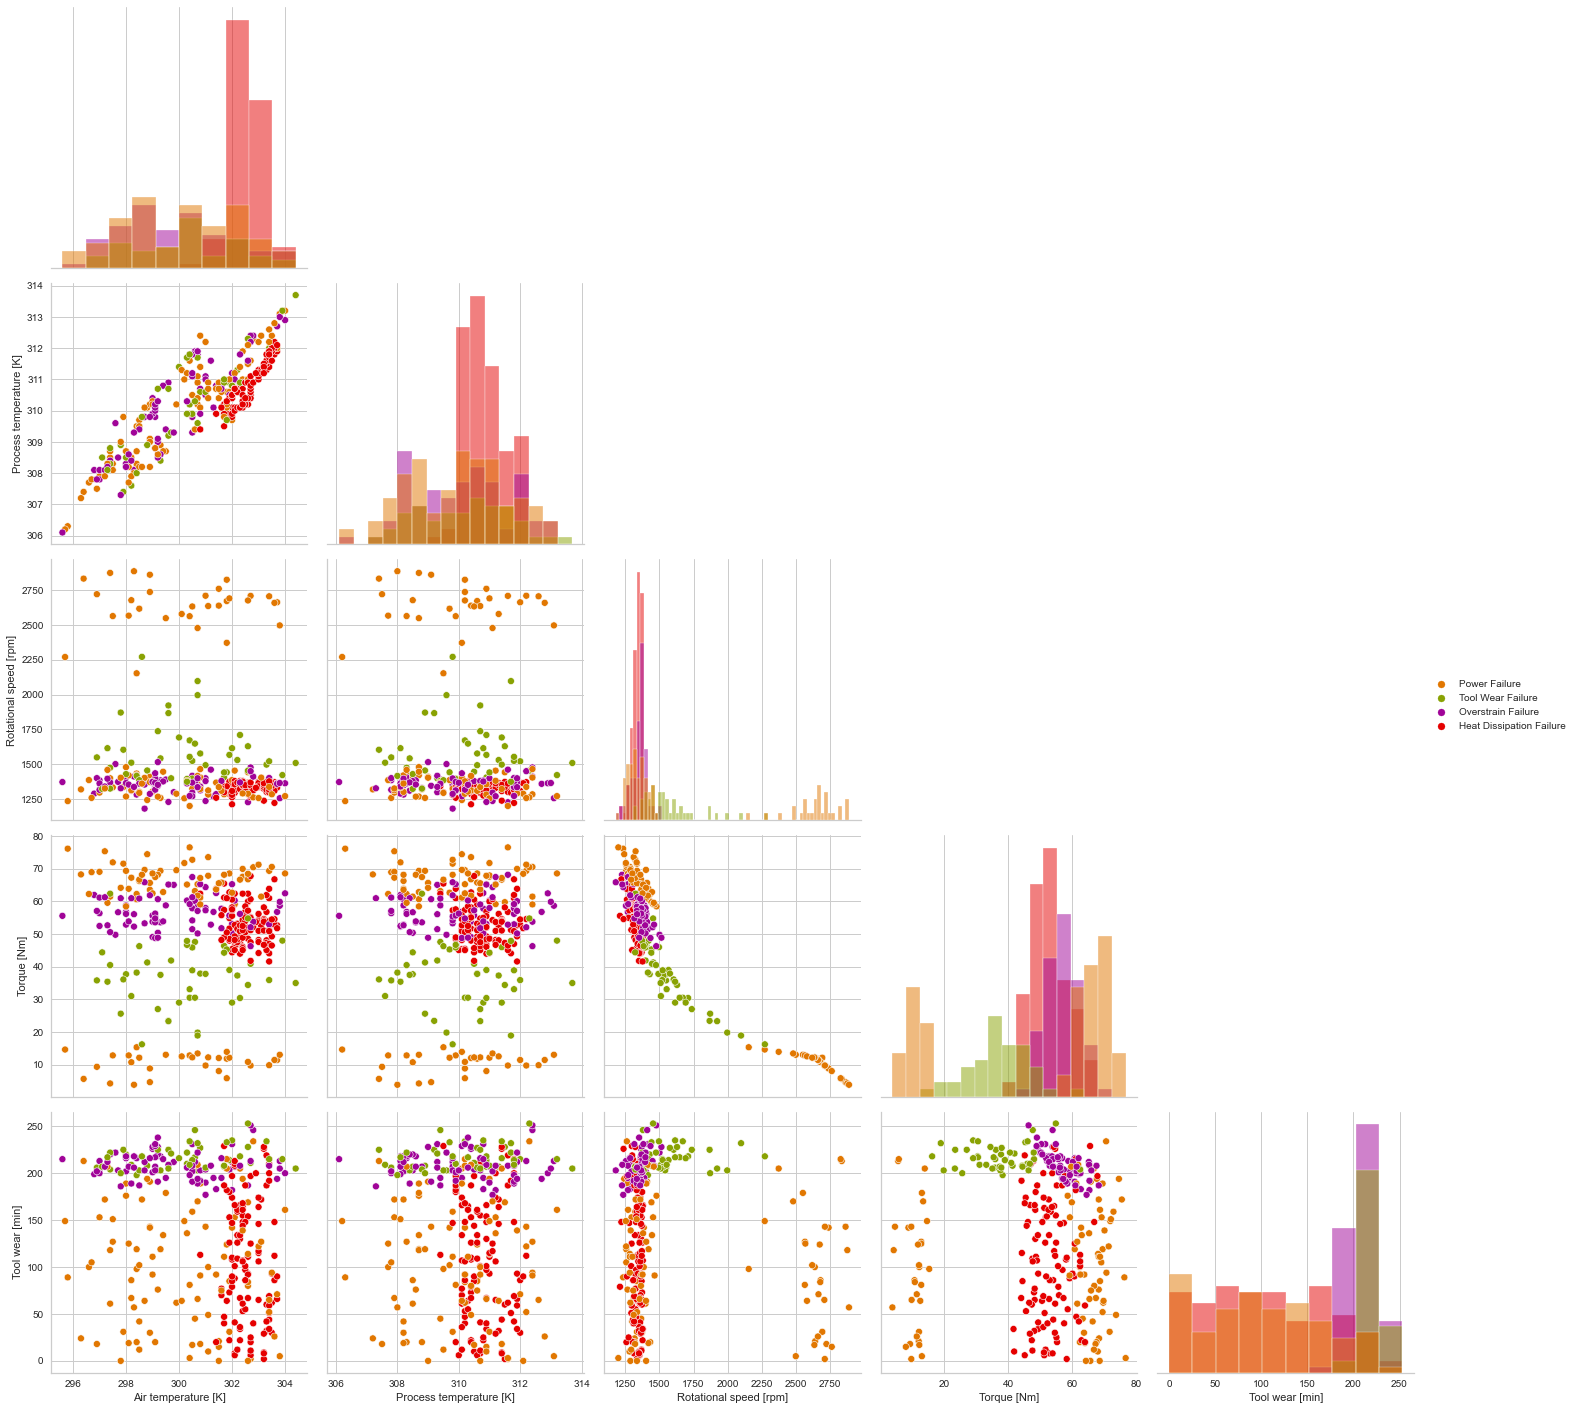

In [17]:
df1plot2 = df1plot1[df1plot1['Failure Type'] != 'No Failure']

g = sns.PairGrid(df1plot2, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", )
plt.savefig('images/Machine-Failures-Scatter.png');

 The Air temperature and process temperature do have some sort of correlation to Heat dissipation BUT considering this machine is meant to cut parts and not heat anything to bake, cook, or cure parts, the air temperature alone cannot be causing the failure. It is only an indication for the failure.
 
 Overall though, it seems that all of the features play varying roles into each of the failures, but it does seem that we would not be able to directly correlate a feature with a failure type



## Preparing the Data for Modeling

We will take the data now, remove the unnecessary columns, and split the data into test and train sets

In [18]:
# View data in working dataset
df3

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,298.1,308.6,1551.0,42.8,0.0,0.0,1
1,1,298.2,308.7,1408.0,46.3,3.0,0.0,1
2,1,298.1,308.5,1498.0,49.4,5.0,0.0,1
3,1,298.2,308.6,1433.0,39.5,7.0,0.0,1
4,1,298.2,308.7,1408.0,40.0,9.0,0.0,1
...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604.0,29.5,14.0,0.0,1
9996,0,298.9,308.4,1632.0,31.8,17.0,0.0,1
9997,2,299.0,308.6,1645.0,33.4,22.0,0.0,1
9998,0,299.0,308.7,1408.0,48.5,25.0,0.0,1


In [19]:
# get value counts on all columns again
df3['Failure Type'].value_counts()

1    9643
0     112
3      95
2      78
4      45
Name: Failure Type, dtype: int64

In [20]:
# Split data in test and training data
X = df3.drop(['Failure Type', 'Target'], axis=1)
y = df3['Failure Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

The first thing we will do is use smote to balance the data in the training datasets. This should allow the models to train better and have better predictions when operating on the test datasets. We will set the counts of values for failures to be higher than they are now, but we will not want to set them to be the same counts as no failures. That would increase our dataset to process by quite a bit (around 8000 counts per feature would be 40000 rows) and slow down our notebook. 

In [21]:
# set counts of values for each feature
ss = {
    0:5000,
    1:8000,
    2:5000,
    3:5000,
    4:5000,
}

# resample the data using smote
oversample = SMOTE(sampling_strategy=ss,random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

C:\Users\Tim\anaconda3\envs\learn-env\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (8000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 7714)
  warnings.warn(


Lets check the dataset to see what changed

In [22]:
y_train.value_counts()

1    8000
4    5000
3    5000
2    5000
0    5000
Name: Failure Type, dtype: int64

All of the failure types are more balanced, now we can use them for our classifier

## Modeling

As we get into modeling, we will want to consider what the client would like to see in this process. They ultimately want to perform preventative maintenance on the machines, as downtime on the machines can be very costly. So predicting a false negative would be much more acceptable than predicting a false positive. In saying this, they would much rather anticipate a failure, and not have the failure happen, rather than not anticipate the failure and have a failure occur. In this case, we will want to focus on getting as few false negatives (false no failures) as possible.

Since our test set is imbalanced, we will want to take into account what error percentage we would obtained if the model predicted every values as a no failure.

In [23]:
# Get percentage of failures in out test dataset
y_test_values = y_test.value_counts()
str(round(((sum(y_test_values.loc[[0,2,3,4]]) / y_test_values.loc[1])*100), 2)) + '%'

'3.42%'

So 3.42% of our test set are failures. If we predicted no failure for every instance, we would get 96.58% correct. So we will want our accuracy scores to be higher than this if possible, but ultimately accuracy will not play a large role into the metrics we use to determine model performance.

Lets start out applying the data to KNeighbors classifier to see what we get. 

Classification_Report: 
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.10      0.55      0.16        22
              No Failure       0.99      0.88      0.93      1929
      Overstrain Failure       0.36      0.62      0.45        16
           Power Failure       0.28      0.58      0.38        19
       Tool Wear Failure       0.06      0.56      0.11         9

                accuracy                           0.87      1995
               macro avg       0.36      0.64      0.41      1995
            weighted avg       0.96      0.87      0.91      1995



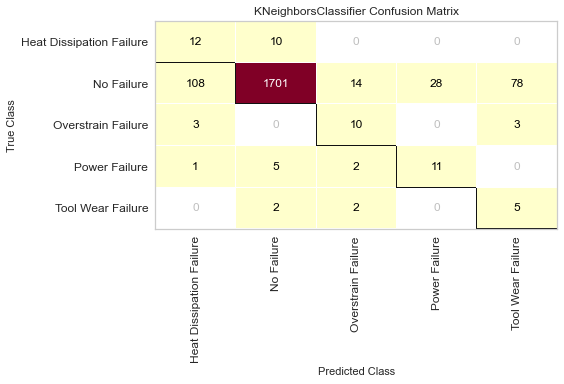

In [24]:
# Create Kneighbors classifier model
clf1 = KNeighborsClassifier()
clf1.fit(X_train, y_train)
y_pred_clf1 = clf1.predict(X_test)
print("Classification_Report: \n", classification_report(y_test, y_pred_clf1, target_names=classes, zero_division=1))

# classes = [0, 1, 2, 3, 4]

clf1_cm = ConfusionMatrix(
    clf1, classes=classes
)

clf1_cm.fit(X_train, y_train)
clf1_cm.score(X_test, y_test)
clf1_cm.show();


That model performed pretty terribly. Lets try a decision tree classifier, and then perform grid search on it to improve the results

In [25]:
# Grid search scoring metric
score = 'f1_weighted'

In [26]:
# Create values for grid search CV
param_grid = {'criterion':['gini','entropy'],
              'max_depth':[10,12,14],
              'min_samples_leaf': [1,5]
             }

BBC Baseline Classification_Report: 
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.65      1.00      0.79        22
              No Failure       1.00      0.97      0.98      1929
      Overstrain Failure       0.72      0.81      0.76        16
           Power Failure       0.68      0.79      0.73        19
       Tool Wear Failure       0.09      0.33      0.14         9

                accuracy                           0.97      1995
               macro avg       0.63      0.78      0.68      1995
            weighted avg       0.98      0.97      0.97      1995



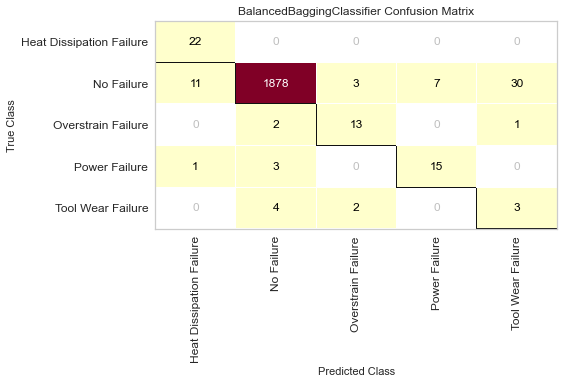

In [27]:
# Create baseline dt model
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X_train, y_train)
y_pred_BBC = bbc.predict(X_test)

print("BBC Baseline Classification_Report: \n", classification_report(y_test, y_pred_BBC, target_names=classes))

bbc_cm = ConfusionMatrix(
    bbc, classes= classes
)

bbc_cm.fit(X_train, y_train)
bbc_cm.score(X_test, y_test)
bbc_cm.show(outpath='images/RFC-BBC.png');

Well that was a significant improvement from the nearest neighbors. Bagging ended up only predicting 9 no failures when they were actually failures. Lets look at the roc and auc curves

In [28]:
# Import yellowbrick for ROCAUC. Create function to automatically fit and plot ROC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=classes)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

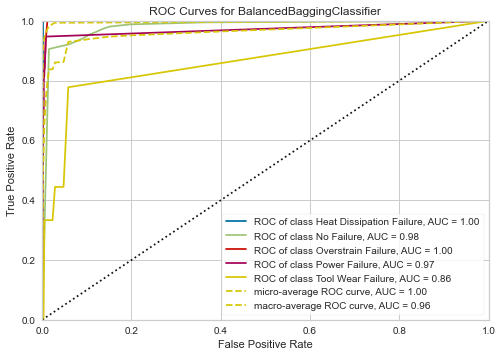

In [29]:
# Plot ROC curve
plot_ROC_curve(bbc, X_train, y_train, X_test, y_test);

This plot makes sense for the classification report we saw previously. Tool wear failure performed the worst out of all of the failure categories. Luckily tool wear is the category which is the easiest to prevent, as long as the tool is exchanged prior to it being worn out. We can try random forest classifier to see if that yields better results

RF Baseline Classification Report: 
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.62      0.95      0.75        22
              No Failure       0.99      0.98      0.98      1929
      Overstrain Failure       0.72      0.81      0.76        16
           Power Failure       0.74      0.74      0.74        19
       Tool Wear Failure       0.14      0.44      0.22         9

                accuracy                           0.97      1995
               macro avg       0.64      0.78      0.69      1995
            weighted avg       0.98      0.97      0.97      1995



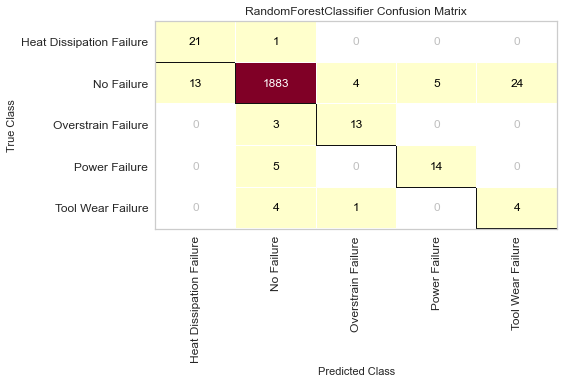

In [30]:
# Create baseline random forest model
rf = RandomForestClassifier(class_weight= 'balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF Baseline Classification Report: \n", classification_report(y_test, y_pred_rf,target_names=classes))

rf_cm = ConfusionMatrix(
    rf, classes= classes
)

rf_cm.fit(X_train, y_train)
rf_cm.score(X_test, y_test)
rf_cm.show();

ok, did not perform as well as the bagging classifier. Lets try and make a quick grid search to better tune the model.

In [31]:
# Fit grid search to random forest classifier
grid_rfc = GridSearchCV(rf, param_grid, cv = 3, scoring=score)
grid_rfc.fit(X_train, y_train)
grid_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1}

RF Optimized Classification_Report: 
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.59      1.00      0.75        22
              No Failure       0.99      0.96      0.97      1929
      Overstrain Failure       0.68      0.81      0.74        16
           Power Failure       0.70      0.74      0.72        19
       Tool Wear Failure       0.08      0.56      0.14         9

                accuracy                           0.95      1995
               macro avg       0.61      0.81      0.66      1995
            weighted avg       0.98      0.95      0.96      1995



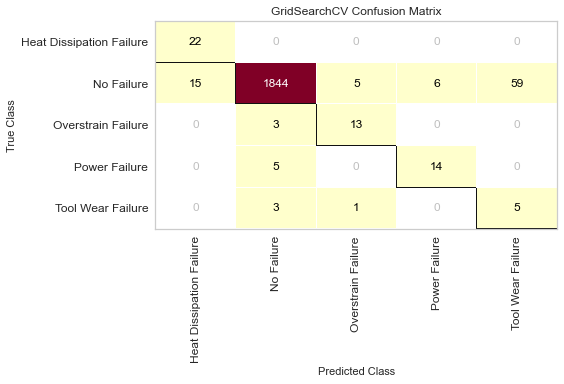

In [32]:
# Create optimized rf model
y_pred_rf2 = grid_rfc.predict(X_test)

print("RF Optimized Classification_Report: \n", classification_report(y_test, y_pred_rf2, target_names=classes))

rfc_cm = ConfusionMatrix(
    grid_rfc, classes= classes
)

rfc_cm.fit(X_train, y_train)
rfc_cm.score(X_test, y_test)
rfc_cm.show();

 Weighted F1 score is 96% and it predicted 11 failures as no failures, which is slightly worse than the bagging but better than the previous model. But it also predicted many more incorrect instances of tool wear failure. We might be able to fix this in tuning the parameters. For now lets take a look at the ROC curves

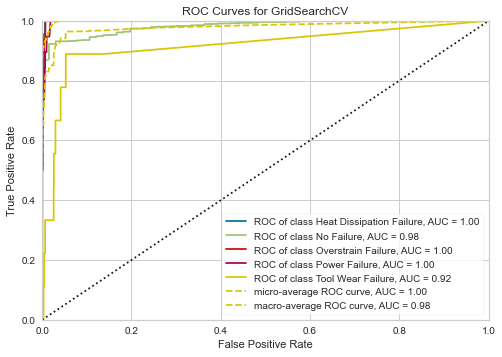

In [33]:
# Plot ROC curves
plot_ROC_curve(grid_rfc, X_train, y_train, X_test, y_test);

Pretty good. All with the exception of tool wear, but we did decide earlier that the tool wear failure is the least important to solve for due to cost of the failure.

## Scaled models

Lets scale the models in a pipeline and see how they perform in comparison to the previous baseline models

In [34]:
%%time
# Create scaled Pipeline for random forest and decision tree
pipe_rf_scale = Pipeline([('ss', StandardScaler()),
                 ('RF', RandomForestClassifier(class_weight = 'balanced', random_state=42))])

pipe_bbc_scale = Pipeline([('ss', StandardScaler()),
                 ('BBC', BalancedBaggingClassifier(random_state=42))])

# Fit both pipelines to training data
pipe_rf_scale.fit(X_train, y_train)

pipe_bbc_scale.fit(X_train, y_train)

Wall time: 4.65 s


Pipeline(steps=[('ss', StandardScaler()),
                ('BBC', BalancedBaggingClassifier(random_state=42))])

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.63      1.00      0.77        22
              No Failure       0.99      0.97      0.98      1929
      Overstrain Failure       0.65      0.81      0.72        16
           Power Failure       0.70      0.74      0.72        19
       Tool Wear Failure       0.14      0.44      0.21         9

                accuracy                           0.97      1995
               macro avg       0.62      0.79      0.68      1995
            weighted avg       0.98      0.97      0.97      1995



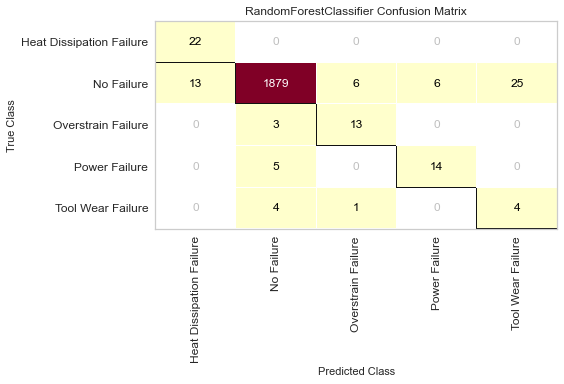

In [35]:
# Predict values
y_preds_pipe_rf_scale= pipe_rf_scale.predict(X_test)

# Print classification report and confusion matrix for random forest pipeline
print(classification_report(y_test, y_preds_pipe_rf_scale, target_names=classes))

cmpipe_rf_scale= ConfusionMatrix(
    pipe_rf_scale, classes= classes
)

cmpipe_rf_scale.fit(X_train, y_train)
cmpipe_rf_scale.score(X_test, y_test)
cmpipe_rf_scale.show(outpath='images/RFC-CM.png');

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.65      1.00      0.79        22
              No Failure       1.00      0.97      0.98      1929
      Overstrain Failure       0.72      0.81      0.76        16
           Power Failure       0.68      0.79      0.73        19
       Tool Wear Failure       0.09      0.33      0.14         9

                accuracy                           0.97      1995
               macro avg       0.63      0.78      0.68      1995
            weighted avg       0.98      0.97      0.97      1995



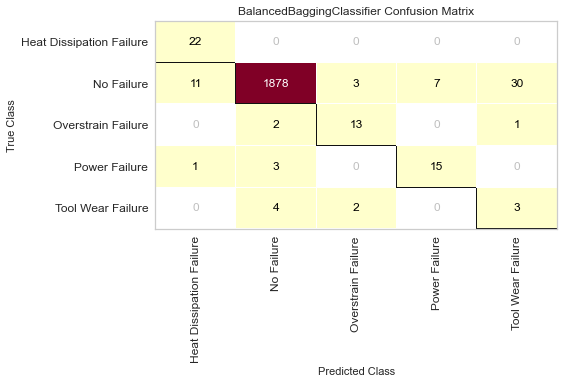

In [36]:
# Predict values
y_preds_pipe_bbc_scale= pipe_bbc_scale.predict(X_test)

# Print classification report and confusion matrix for bagging pipeline
print(classification_report(y_test, y_preds_pipe_bbc_scale, target_names=classes))

cmpipe_bbc_scale= ConfusionMatrix(
    pipe_bbc_scale, classes= classes
)

cmpipe_bbc_scale.fit(X_train, y_train)
cmpipe_bbc_scale.score(X_test, y_test)
cmpipe_bbc_scale.show();


Looks like the bagging algorithm performed the same as before, and the random forest actually performed slightly worse when scaled, so we will not scale the data going forward.

## Gridsearch Random Forest

The previous scores we got for the random tree were really good. Lets see if we can make them better through a scaler though. We will run this through a pipeline and determine the best parameters for gridsearch by first running randomized search to see where we should hone in on parameters, and then apply those to gridsearch to determine the best parameters.

In [37]:
pgrid_rf = [{'RF__n_estimators':[10, 50, 100, 200, 250, 300],
         'RF__criterion':['gini', 'entropy'],
         'RF__max_depth': [None, 5, 10, 50], 
         'RF__min_samples_split': [2, 5, 10, 13], 
         'RF__min_samples_leaf': [1, 5, 7, 9]}]

In [38]:
%%time
# Create scaled Pipeline for random forest and decision tree
pipe_rf = Pipeline([('RF', RandomForestClassifier(class_weight = 'balanced', random_state=42))])

# Assigning values to randomizedsearch for in each pipeline
randomsearch_rf = RandomizedSearchCV(estimator=pipe_rf, 
                          n_iter=50,
                          param_distributions=pgrid_rf, 
                          scoring=score, 
                          cv=5,
                          random_state=42)

# fit training data on rf
randomsearch_rf.fit(X_train, y_train)

Wall time: 16min 43s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('RF',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=50,
                   param_distributions=[{'RF__criterion': ['gini', 'entropy'],
                                         'RF__max_depth': [None, 5, 10, 50],
                                         'RF__min_samples_leaf': [1, 5, 7, 9],
                                         'RF__min_samples_split': [2, 5, 10,
                                                                   13],
                                         'RF__n_estimators': [10, 50, 100, 200,
                                                              250, 300]}],
                   random_state=42, scoring='f1_weighted')

In [39]:
randomsearch_rf.best_params_

{'RF__n_estimators': 300,
 'RF__min_samples_split': 5,
 'RF__min_samples_leaf': 1,
 'RF__max_depth': 50,
 'RF__criterion': 'gini'}

So it would seem we want parameters to be around 300 for n_estimators, around 50 for max_depth, and around 5 for samples split. Lets run it through gridsearch to see what we come up with.

In [40]:
# CReate parameters for gridsearch
pgrid_rf2 = [{'RF__n_estimators':[275, 300, 325],
         'RF__criterion':['gini'],
         'RF__max_depth': [30, 40, 50], 
         'RF__min_samples_split': [5], 
         'RF__min_samples_leaf': [1]}]

In [41]:
%%time
# Assigning values to gridsearch for in each pipeline
gridsearch_rf1 = GridSearchCV(estimator=pipe_rf, 
                          param_grid=pgrid_rf2, 
                          scoring=score, 
                          cv=5)

# fit training data on rf
gridsearch_rf1.fit(X_train, y_train)

Wall time: 6min 2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid=[{'RF__criterion': ['gini'],
                          'RF__max_depth': [30, 40, 50],
                          'RF__min_samples_leaf': [1],
                          'RF__min_samples_split': [5],
                          'RF__n_estimators': [275, 300, 325]}],
             scoring='f1_weighted')

In [42]:
gridsearch_rf1.best_params_

{'RF__criterion': 'gini',
 'RF__max_depth': 30,
 'RF__min_samples_leaf': 1,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 325}

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.60      0.95      0.74        22
              No Failure       0.99      0.97      0.98      1929
      Overstrain Failure       0.76      0.81      0.79        16
           Power Failure       0.70      0.74      0.72        19
       Tool Wear Failure       0.12      0.44      0.20         9

                accuracy                           0.97      1995
               macro avg       0.64      0.78      0.68      1995
            weighted avg       0.98      0.97      0.97      1995



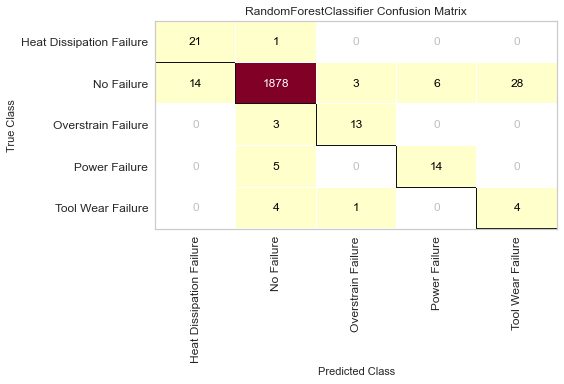

In [43]:
# set new classifier to best estimators
rf_best1 = gridsearch_rf1.best_estimator_

# Predict values
y_preds_pipe_rf1= rf_best1.predict(X_test)

# Print classification report and confusion matrix for random forest pipeline
print(classification_report(y_test, y_preds_pipe_rf1, target_names=classes))

cmpipe_rf1= ConfusionMatrix(
    rf_best1, classes= classes
)

cmpipe_rf1.fit(X_train, y_train)
cmpipe_rf1.score(X_test, y_test)
cmpipe_rf1.show(outpath='images/RFC-CM.png');

Our hypertuned parameters model certainly worked better than the previous gridsearch model! But the F1 scores are still so close to the bagging classifier model results. For the simple fact that the scores are so close, and that the bagging classifier predicted less no failures incorrectly (predicted less false negatives) we will use the bagging classifier going forward. Lets use it on a binary classifier to see the results

              precision    recall  f1-score   support

  No Failure       1.00      0.92      0.96      1929
     Failure       0.28      0.91      0.42        66

    accuracy                           0.92      1995
   macro avg       0.64      0.91      0.69      1995
weighted avg       0.97      0.92      0.94      1995



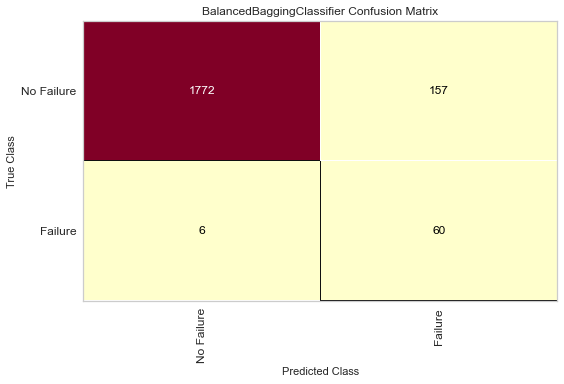

In [44]:
X = df3.drop(['Failure Type', 'Target'], axis=1)
y = df3['Target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

# fit training data on rf
bbc.fit(X_train2, y_train2)

y_preds_pipe_bbc3 = bbc.predict(X_test2)

print(classification_report(y_test2, y_preds_pipe_bbc3, target_names=['No Failure', 'Failure']))

cmpipe_bbc1 = ConfusionMatrix(
    bbc, classes = ['No Failure', 'Failure']
)

cmpipe_bbc1.fit(X_train2, y_train2)
cmpipe_bbc1.score(X_test2, y_test2)
cmpipe_bbc1.show(outpath='images/BBC-CM2.png');

We got alot of false positives at 157, but again we are looking to reduce the false negatives ultimately, which we only got 6 incorrect.

## Trim data and Remodel

The manufacturer should be able to implement procedures where the operator or machine will avoid certain parameter thresholds. For example, if you go to machine a part and the amperage at the machine reaches a certain number, then the machine should stop itself to prevent an error from occuring. If these threshold were put in place, then the amount of failures would certainly be reduced.


We should take a look at the most important feature (using our last random forest model and the feature importance method for that model), trim the outliers in that feature to remove a good portion of failure, and then re predict how many failures we think will occur in this scenario. This should improve our accuracy score and our recall score for "No Failure"

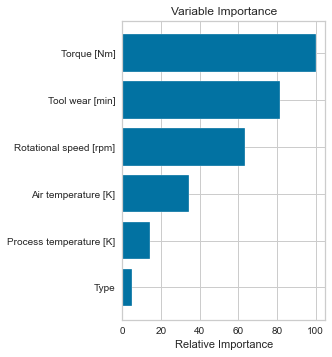

In [46]:
# Plot feature importance
feature_importance = cmpipe_rf1.steps[0][1].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df3.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('images/Variable-Importance.png')
plt.show();

It seems that torque is the most important variable. So we will take the dataset, remove the values that are outliers for this feature, and rerun our best model to see how many failures and what kind of failures the model predicts. Is our original plots, it looks like most of the failures fell under 20Nm or over 58 Nm. Lets see what the data gives us.

In [47]:
df3['Torque [Nm]'].describe()

count    9973.000000
mean       39.978993
std         9.966805
min         3.800000
25%        33.200000
50%        40.100000
75%        46.700000
max        76.600000
Name: Torque [Nm], dtype: float64

Upper bound:66.8 Lower bound:13.0


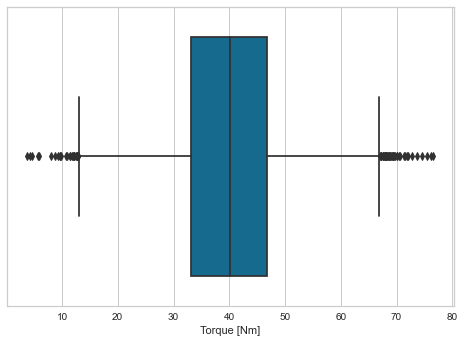

In [48]:
# Calculate median, upper quartile, lower quartile, upper whisk, and lower whisk. Create box plot from torque column
median = np.median(df3['Torque [Nm]'])
upper_quartile = np.percentile(df3['Torque [Nm]'], 75)
lower_quartile = np.percentile(df3['Torque [Nm]'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df3['Torque [Nm]'][df3['Torque [Nm]']<=upper_quartile+1.5*iqr].max()
lower_whisker = df3['Torque [Nm]'][df3['Torque [Nm]']>=lower_quartile-1.5*iqr].min()

sns.boxplot(df3['Torque [Nm]']);
print('Upper bound:' + str(upper_whisker), 'Lower bound:' + str(lower_whisker))

The upper bound and lower bound are at 13 and 67 respectively, but we know from our plots that there are many other failures in this range, so we will tweak the numbers to eliminate those additional range where the probability of failure is higher. Lets have the IQR times 1 instead of 1.5

In [49]:
# recalculate numbers but in upper whisker and lower whisker multiply IQR by 1
median = np.median(df3['Torque [Nm]'])
upper_quartile = np.percentile(df3['Torque [Nm]'], 75)
lower_quartile = np.percentile(df3['Torque [Nm]'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df3['Torque [Nm]'][df3['Torque [Nm]']<=upper_quartile+1*iqr].max()
lower_whisker = df3['Torque [Nm]'][df3['Torque [Nm]']>=lower_quartile-1*iqr].min()

print('Adjusted Upper bound:' + str(upper_whisker), 'Adjusted Lower bound:' + str(lower_whisker))

Adjusted Upper bound:60.2 Adjusted Lower bound:19.8


In [50]:
# Create new dataframe with adjusted upper and lower torque bounds removed
Torquedrop = df3[(df3['Torque [Nm]'] <=lower_whisker) | (df3['Torque [Nm]'] >= upper_whisker)].index
df4 = df3.copy()
df4.drop(Torquedrop, inplace=True)
df4.reset_index(drop=True, inplace=True)
df4

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,298.1,308.6,1551.0,42.8,0.0,0.0,1
1,1,298.2,308.7,1408.0,46.3,3.0,0.0,1
2,1,298.1,308.5,1498.0,49.4,5.0,0.0,1
3,1,298.2,308.6,1433.0,39.5,7.0,0.0,1
4,1,298.2,308.7,1408.0,40.0,9.0,0.0,1
...,...,...,...,...,...,...,...,...
9516,2,298.8,308.4,1604.0,29.5,14.0,0.0,1
9517,0,298.9,308.4,1632.0,31.8,17.0,0.0,1
9518,2,299.0,308.6,1645.0,33.4,22.0,0.0,1
9519,0,299.0,308.7,1408.0,48.5,25.0,0.0,1


In [51]:
df4['Failure Type'].value_counts()

1    9323
0      96
2      56
4      41
3       5
Name: Failure Type, dtype: int64

Looks like we reduced our failures from 303 to now 198 by just excluding data that was outlying on the torque boxplot. 

There are only 5 power failures. We will not be able to have enough data to train the set on, and we will not even have enough data points in this failure case to smote this area. So we will remove these remaining 5 power failures

In [52]:
# remove power failures from dataframe
df5 = df4[df4['Failure Type'] != 3]

In [53]:
# convert all '4' values to '3' in failure type column
df6 = df5.copy()
df6['Failure Type'] = df5['Failure Type'].replace(to_replace=4, value=3)
df6['Failure Type'].value_counts()

1    9323
0      96
2      56
3      41
Name: Failure Type, dtype: int64

Now that we have our new dataframe, we will run it through the same steps for our scaled random forest model to see how many failures it predicts we will encounter in our new dataset. We will run a model for the failure type column and a model for the target column

In [54]:
# create train and test sets. as well as smote dataframe
X = df6.drop(['Failure Type', 'Target'], axis=1)
y = df6['Failure Type']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

ss1 = {
    0:5000,
    1:9400,
    2:5000,
    3:5000
}

oversample1 = SMOTE(sampling_strategy=ss1,random_state=42)
X_train3, y_train3 = oversample1.fit_resample(X_train3, y_train3)

C:\Users\Tim\anaconda3\envs\learn-env\lib\site-packages\imblearn\utils\_validation.py:318: UserWarning: After over-sampling, the number of samples (9400) in class 1 will be larger than the number of samples in the majority class (class #1 -> 7457)
  warnings.warn(


In [55]:
# remove power failures from classes and create new set of classes to display
classes1 = classes[:3] + classes[4:]
classes1

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Tool Wear Failure']

In [56]:
# fit training data on rf
bbc.fit(X_train3, y_train3)

# Predict values
y_preds_pipe_bbc4 = bbc.predict(X_test3)



In [57]:
# return predictions for failures where 0, 2, and 3 are failures
values, counts = np.unique(y_preds_pipe_bbc4, return_counts=True)
list(zip(values, counts))

[(0, 23), (1, 1842), (2, 14), (3, 25)]

It looks like our model predicted 55 instances of failure in this new dataset. 

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.78      0.95      0.86        19
              No Failure       0.99      0.98      0.99      1866
      Overstrain Failure       0.57      0.73      0.64        11
       Tool Wear Failure       0.08      0.25      0.12         8

                accuracy                           0.98      1904
               macro avg       0.61      0.73      0.65      1904
            weighted avg       0.99      0.98      0.98      1904



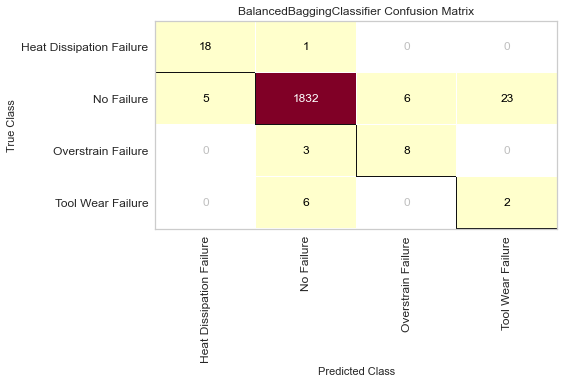

In [58]:

# Print classification report and confusion matrix for random forest pipeline
print(classification_report(y_test3, y_preds_pipe_bbc4, target_names=classes1))

cmpipe_rf4 = ConfusionMatrix(
    bbc, classes= classes1
)

cmpipe_rf4.fit(X_train3, y_train3)
cmpipe_rf4.score(X_test3, y_test3)
cmpipe_rf4.show(outpath='images/BBC-CM3.png');

              precision    recall  f1-score   support

  No Failure       1.00      0.92      0.96      1865
     Failure       0.20      0.97      0.33        39

    accuracy                           0.92      1904
   macro avg       0.60      0.95      0.64      1904
weighted avg       0.98      0.92      0.94      1904



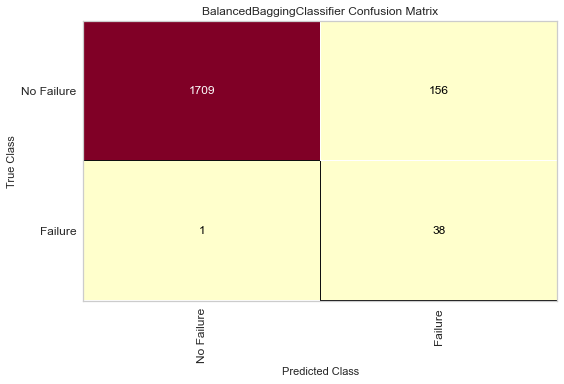

In [59]:
X = df6.drop(['Failure Type', 'Target'], axis=1)
y = df6['Target']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

# fit training data on rf
bbc.fit(X_train4, y_train4)

y_preds_pipe_bbc5 = bbc.predict(X_test4)

print(classification_report(y_test4, y_preds_pipe_bbc5, target_names=['No Failure', 'Failure']))

cmpipe_rf5 = ConfusionMatrix(
    bbc, classes = ['No Failure', 'Failure']
)

cmpipe_rf5.fit(X_train4, y_train4)
cmpipe_rf5.score(X_test4, y_test4)
cmpipe_rf5.show(outpath='images/BBC-CM4.png');

In [60]:
# return values for failures where 0, 2, and 3 are failures
values, counts = np.unique(y_preds_pipe_bbc5, return_counts=True)
list(zip(values, counts))

[(0.0, 1710), (1.0, 194)]

## Conclusion

#### Failures

- All of the types of failures have a relationship with each of the features presented in the data. There is no one to one correlation, as each one is affected in varying degrees by many of the features.
- Our highest counts of failure (in order from highest to lowest) are: Heat dissipation, Power Failure, Overstrain, and Tool Wear (random failures excluded).

#### Model

- Our final models show that by removing the outliers for torque, not only did we decrease the amount of failures, but we also decreased the amount of false negatives predicted down to only one in the last binary model. By focusing on the most important feature (as according to our random forest model) and removing those outliers, we were able to reduce failure and increase the performance of our model.